In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


In [2]:
data = pd.read_csv(filepath_or_buffer="./Data/clean_data_new.csv", index_col="date")

In [3]:
#data.head()

In [72]:
#data.tail()

,TCMNOM_Y10,TCMNOM_Y2,DCOILBRENTEU,spindx,GOLDPMGBD228NLBM,exalus,exjpus,exukus
date,,,,,,,,
20181029,3.08,2.81,77.56,2641.25,1230.80,1.4136,112.49,0.7808
20181030,3.12,2.84,75.68,2682.63,1225.40,1.4061,112.76,0.7855
20181031,3.15,2.87,74.84,2711.74,1214.95,1.4104,112.86,0.7825
20181101,3.14,2.84,71.25,2740.37,1231.15,1.3910,112.79,0.7708
20181102,3.22,2.91,71.11,2723.06,1232.10,1.3891,113.09,0.7713


In [73]:
#data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7931 entries, 19870520 to 20181102
Data columns (total 8 columns):
TCMNOM_Y10          7931 non-null float64
TCMNOM_Y2           7931 non-null float64
DCOILBRENTEU        7931 non-null float64
spindx              7931 non-null float64
GOLDPMGBD228NLBM    7931 non-null float64
exalus              7931 non-null float64
exjpus              7931 non-null float64
exukus              7931 non-null float64
dtypes: float64(8)
memory usage: 557.6 KB


In [4]:
data = data.apply(pd.to_numeric, errors = "coerce")

In [5]:
#btc_trace = go.Scatter(x=data.index, y=data['spindx'], name= 'spi')
#py.iplot([btc_trace])

In [6]:
data['spindx'].replace(0, np.nan, inplace=True)
data['spindx'].fillna(method='ffill', inplace=True)

In [7]:
#reshaping prediction value into value range -1 to 1
from sklearn.preprocessing import MinMaxScaler

In [8]:
values = data['spindx'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [79]:
#values

array([[ 278.21],
       [ 280.17],
       [ 282.16],
       ...,
       [2711.74],
       [2740.37],
       [2723.06]], dtype=float32)

In [80]:
#scaled

array([[0.02005667],
       [0.02078077],
       [0.02151594],
       ...,
       [0.9190898 ],
       [0.92966676],
       [0.9232718 ]], dtype=float32)

In [81]:
#split dataset into train and test, 70% train 30% test

In [82]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

5551 2380


In [83]:
#function that convert the dataset to be 3d
def create_dataset(dataset, look_back=1, predict_forward = 1-1): #predict_forward = 0 means predict the next day
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - predict_forward):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back+predict_forward, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [223]:
look_back = 1 #use 3 previous days to predict the next day
predict_foward = 7 #user input
trainX, trainY = create_dataset(train, look_back, predict_foward-1)
testX, testY = create_dataset(test, look_back, predict_foward-1)

5537
2366


In [224]:
trainX[0]

array([0.02005667], dtype=float32)

In [225]:
trainY[0]

0.027172007

In [226]:
#reshaping data into 3-D
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [227]:
trainX

array([[[0.02005667]],

       [[0.02078077]],

       [[0.02151594]],

       ...,

       [[0.2397232 ]],

       [[0.24146327]],

       [[0.2524429 ]]], dtype=float32)

In [228]:
#run the model
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=35, batch_size=100, validation_data=(testX, testY), verbose=1, shuffle=False)

Train on 5537 samples, validate on 2366 samples
Epoch 1/35
5537/5537 [==============================] - 3s 529us/step - loss: 0.0568 - val_loss: 0.1217
Epoch 2/35
5537/5537 [==============================] - 0s 73us/step - loss: 0.1282 - val_loss: 0.1077
Epoch 3/35
5537/5537 [==============================] - 0s 72us/step - loss: 0.1008 - val_loss: 0.0740
Epoch 4/35
5537/5537 [==============================] - 0s 74us/step - loss: 0.0836 - val_loss: 0.0500
Epoch 5/35
5537/5537 [==============================] - 0s 72us/step - loss: 0.0643 - val_loss: 0.0340
Epoch 6/35
5537/5537 [==============================] - 0s 72us/step - loss: 0.0433 - val_loss: 0.0265
Epoch 7/35
5537/5537 [==============================] - 0s 73us/step - loss: 0.0256 - val_loss: 0.0235
Epoch 8/35
5537/5537 [==============================] - 0s 70us/step - loss: 0.0197 - val_loss: 0.0145
Epoch 9/35
5537/5537 [==============================] - 0s 67us/step - loss: 0.0178 - val_loss: 0.0145
Epoch 10/35
5537/5537 [=

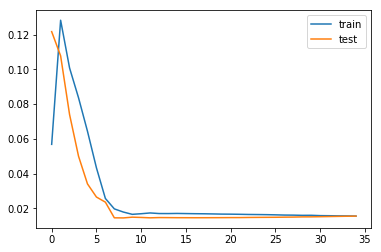

In [229]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

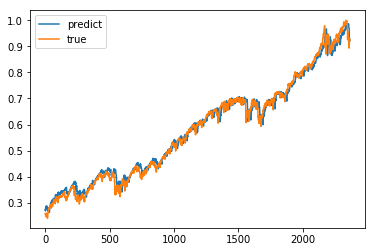

In [230]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [231]:
#inverse y back to values
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

In [232]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 56.077


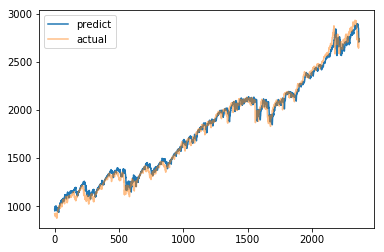

In [233]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

In [234]:
#convert back to normal 
predictDates = data.tail(len(testX)).index
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

In [235]:
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])

In [56]:
#sns.heatmap(data.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)

In [728]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [729]:
data.columns

Index(['TCMNOM_Y10', 'TCMNOM_Y2', 'DCOILBRENTEU', 'spindx', 'GOLDPMGBD228NLBM',
       'exalus', 'exjpus', 'exukus'],
      dtype='object')

In [730]:
number_of_variables = 8
values = data[['spindx'] + ['TCMNOM_Y2'] + ['TCMNOM_Y10'] + ['DCOILBRENTEU'] + ['GOLDPMGBD228NLBM'] + ['exalus'] + ['exjpus'] + ['exukus']].values
values = values.astype('float32')

In [732]:
values

array([[2.78210e+02, 8.05000e+00, 8.92000e+00, ..., 1.38200e+00,
        1.39780e+02, 5.94200e-01],
       [2.80170e+02, 8.06000e+00, 8.87000e+00, ..., 1.38640e+00,
        1.40450e+02, 5.95600e-01],
       [2.82160e+02, 7.97000e+00, 8.78000e+00, ..., 1.38830e+00,
        1.40600e+02, 5.97700e-01],
       ...,
       [2.71174e+03, 2.87000e+00, 3.15000e+00, ..., 1.41040e+00,
        1.12860e+02, 7.82500e-01],
       [2.74037e+03, 2.84000e+00, 3.14000e+00, ..., 1.39100e+00,
        1.12790e+02, 7.70800e-01],
       [2.72306e+03, 2.91000e+00, 3.22000e+00, ..., 1.38910e+00,
        1.13090e+02, 7.71300e-01]], dtype=float32)

In [1027]:
#convert data to become supervised 
look_back = 8
time_steps = 5
series_to_supervised(values, look_back, time_steps)
reframed = series_to_supervised(values, look_back, time_steps)

In [1028]:
#look_back = 5
number_of_variables = 8
#keeping first varible in first period
reframed.drop(reframed.columns[-1 * number_of_variables + 1:], axis=1, inplace=True) 
reframed.drop(reframed.columns[look_back*number_of_variables:-1], axis=1, inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(reframed)

/home/tjiang20/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning:

Data with input dtype float32 were all converted to float64 by MinMaxScaler.



In [1029]:
reframed.shape

(7919, 65)

In [1030]:
n_train_hours = int(len(scaled) * 0.7)
train = scaled[:n_train_hours, :]
test = scaled[n_train_hours:, :]

In [1031]:
scaled

array([[0.02005667, 0.80840165, 0.85214452, ..., 0.82834405, 0.40381331,
        0.02689493],
       [0.02078077, 0.80942627, 0.84650116, ..., 0.7903303 , 0.38332383,
        0.02710181],
       [0.02151595, 0.80020489, 0.83634313, ..., 0.79686395, 0.38360845,
        0.02717201],
       ...,
       [0.93351634, 0.27561474, 0.20203162, ..., 0.43787127, 0.85799661,
        0.91908985],
       [0.95536104, 0.27766392, 0.20203162, ..., 0.43739609, 0.87023337,
        0.92966685],
       [0.95509875, 0.27971312, 0.20541762, ..., 0.42682351, 0.87051782,
        0.92327189]])

In [1032]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [1035]:
train_X

array([[0.02005667, 0.80840165, 0.85214452, ..., 0.42279282, 0.82834405,
        0.40381331],
       [0.02078077, 0.80942627, 0.84650116, ..., 0.42193407, 0.7903303 ,
        0.38332383],
       [0.02151595, 0.80020489, 0.83634313, ..., 0.41927172, 0.79686395,
        0.38360845],
       ...,
       [0.26056678, 0.08606557, 0.2167043 , ..., 0.33055653, 0.24210025,
        0.48747862],
       [0.25318176, 0.07786885, 0.20316029, ..., 0.32643416, 0.23093376,
        0.46784284],
       [0.25285296, 0.07581967, 0.20316029, ..., 0.33029884, 0.22867667,
        0.45702902]])

In [1036]:
#reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(5543, 1, 64) (5543,) (2376, 1, 64) (2376,)


In [1037]:
multi_model = Sequential()
multi_model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
multi_model.add(Dense(1))
multi_model.compile(loss='mae', optimizer='adam')
multi_history = multi_model.fit(train_X, train_y, epochs=40, batch_size=150, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Train on 5543 samples, validate on 2376 samples
Epoch 1/40
5543/5543 [==============================] - 15s 3ms/step - loss: 0.0668 - val_loss: 0.3033
Epoch 2/40
5543/5543 [==============================] - 0s 56us/step - loss: 0.1651 - val_loss: 0.1457
Epoch 3/40
5543/5543 [==============================] - 0s 55us/step - loss: 0.1377 - val_loss: 0.0639
Epoch 4/40
5543/5543 [==============================] - 0s 55us/step - loss: 0.2062 - val_loss: 0.0680
Epoch 5/40
5543/5543 [==============================] - 0s 55us/step - loss: 0.0500 - val_loss: 0.0897
Epoch 6/40
5543/5543 [==============================] - 0s 56us/step - loss: 0.0556 - val_loss: 0.1795
Epoch 7/40
5543/5543 [==============================] - 0s 54us/step - loss: 0.0379 - val_loss: 0.1535
Epoch 8/40
5543/5543 [==============================] - 0s 55us/step - loss: 0.0514 - val_loss: 0.1542
Epoch 9/40
5543/5543 [==============================] - 0s 56us/step - loss: 0.0454 - val_loss: 0.1241
Epoch 10/40
5543/5543 [==

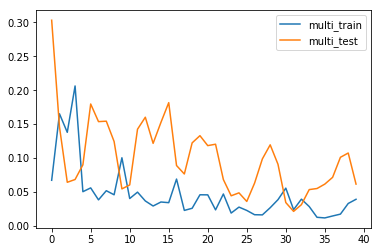

In [1038]:
#plot result 
pyplot.plot(multi_history.history['loss'], label='multi_train')
pyplot.plot(multi_history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

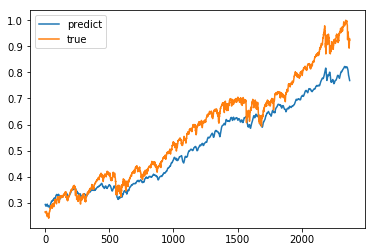

In [1039]:
#plot prediction
yhat = multi_model.predict(test_X)
pyplot.plot(yhat, label='predict')
pyplot.plot(test_y, label='true')
pyplot.legend()
pyplot.show()

In [1040]:
test_X.shape

(2376, 1, 64)

In [1041]:
# invert scaling for prediction
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
test_X[:, :-1]
inv_yhat = concatenate((test_X[:, :], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat.shape
inv_yhat = inv_yhat[:,-1]

In [1042]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, :], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

In [1043]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 199.343


In [1047]:
predictDates = data.tail(len(inv_y)).index
actual_chart = go.Scatter(x=predictDates, y=inv_y, name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat, name= 'Multi Predict Price')
#predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
#py.iplot([predict_chart, multi_predict_chart, actual_chart])
py.iplot([multi_predict_chart, actual_chart])